In [2]:
import scanpy as sc
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib import rcParams
import seaborn as sb

import SpatialDE

plt.rcParams['figure.figsize']=(8,8)

%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append("../PRRR/prrr/models/")
from grrr import GRRR
from prrr import PRRR

In [4]:
adata = sc.read_visium('./data/V1_Mouse_Brain_Sagittal', count_file='V1_Mouse_Brain_Sagittal_Anterior_filtered_feature_bc_matrix.h5')
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
OMP: Info #270: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [5]:
adata.n_obs

2695

In [6]:
sc.pp.filter_cells(adata, min_counts=5000)
sc.pp.filter_cells(adata, max_counts=35000)
adata = adata[adata.obs["pct_counts_mt"] < 20]
print(f"#cells after MT filter: {adata.n_obs}")
sc.pp.filter_genes(adata, min_cells=10)
expression_int = adata.X.todense()

Trying to set attribute `.var` of view, copying.


#cells after MT filter: 2063


In [7]:
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

<AxesSubplot:xlabel='n_genes_by_counts'>

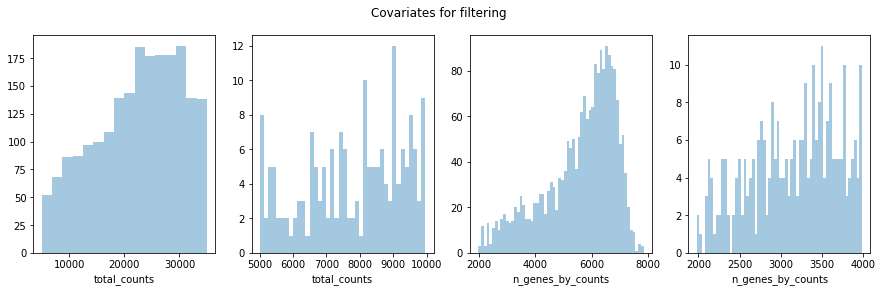

In [8]:
fig, axs = plt.subplots(1,4, figsize=(15,4))
fig.suptitle('Covariates for filtering')
sb.distplot(adata.obs['total_counts'], kde=False, ax = axs[0])
sb.distplot(adata.obs['total_counts'][adata.obs['total_counts']<10000], kde=False, bins=40, ax = axs[1])
sb.distplot(adata.obs['n_genes_by_counts'], kde=False, bins=60, ax = axs[2])
sb.distplot(adata.obs['n_genes_by_counts'][adata.obs['n_genes_by_counts']<4000], kde=False, bins=60, ax = axs[3])

... storing 'feature_types' as categorical
... storing 'genome' as categorical


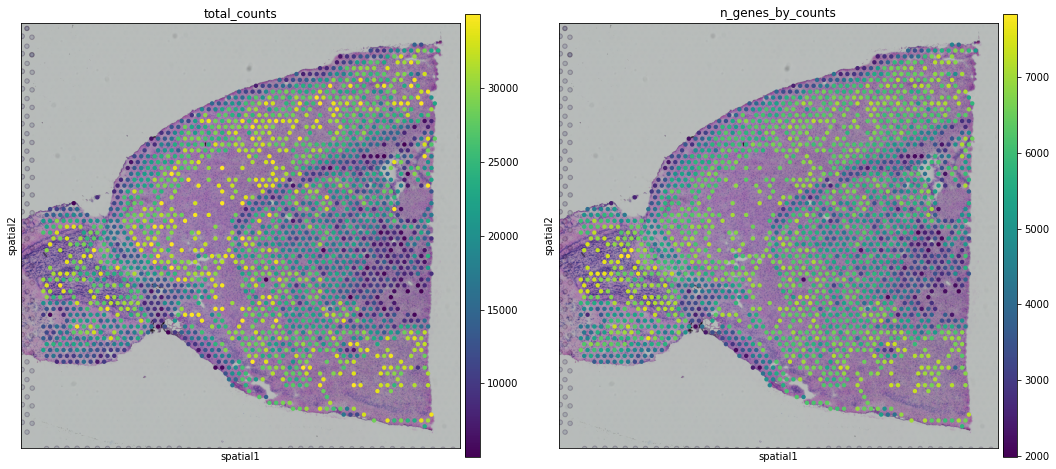

In [9]:
sc.pl.spatial(adata, img_key = "hires",color=['total_counts', 'n_genes_by_counts'])

In [10]:
expression = expression_int[:, adata.var['highly_variable']].astype(int)
coord = adata.obsm['spatial']
coord = (coord - coord.mean(0))/coord.std(0)

In [11]:
expression_sub = expression[:, :1000]
coord_sub = coord[:200, :]

In [12]:
grrr = GRRR(1)
rrr_results = grrr.fit(X=coord, Y=expression, use_vi=False)

Instructions for updating:
The `interpolate_nondiscrete` flag is deprecated; instead use `force_probs_to_zero_outside_support` (with the opposite sense).


2022-03-21 11:21:25.777505: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
A = grrr.param_dict["A"].numpy()
B = grrr.param_dict["B"].numpy()
AB_est_g = A @ B

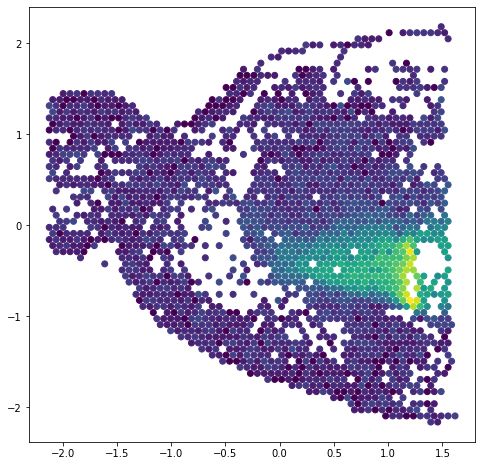

In [14]:
highest = np.argsort(np.abs(B.squeeze()))[-1]
plt.scatter(coord[:, 0], coord[:, 1], c=np.log(np.array(expression[:, highest]).squeeze() + 1))
plt.show()

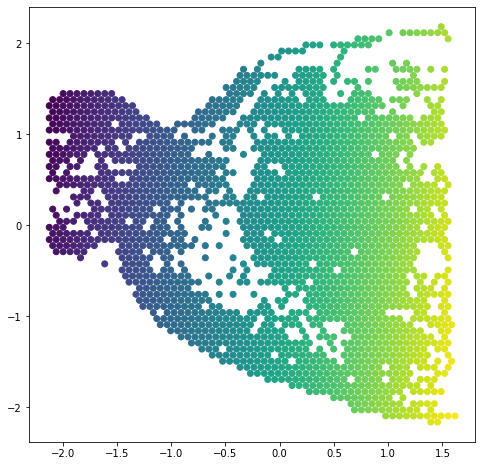

In [15]:
pred = coord @ AB_est_g
plt.scatter(coord[:, 0], coord[:, 1], c=pred[:, highest])
plt.show()

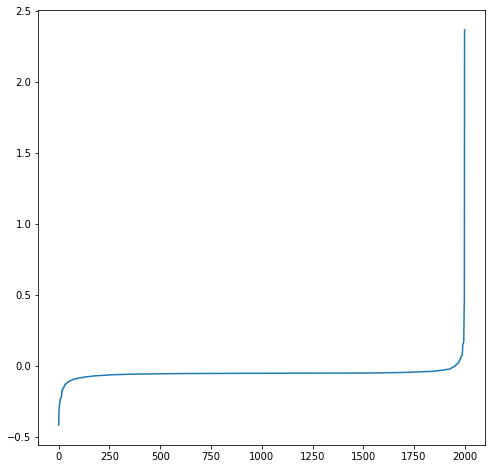

In [228]:
plt.plot(np.sort(B.squeeze()))